In [1]:
import os
INPUT_DIR = '../input/cassava-leaf-disease-classification/'
OUTPUT_DIR = './'
#MODEL_DIR = '../input/cassava-resnext50-32x4d-weights/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
TEST_PATH = '../input/cassava-leaf-disease-classification/test_images'

In [2]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from PIL import Image
import numpy as np
import scipy as sp
import cv2

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [4]:
import json

with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    classes = json.load(f)
    
classes

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [5]:
train['class']=train['label'].apply(lambda x:classes[str(x)])

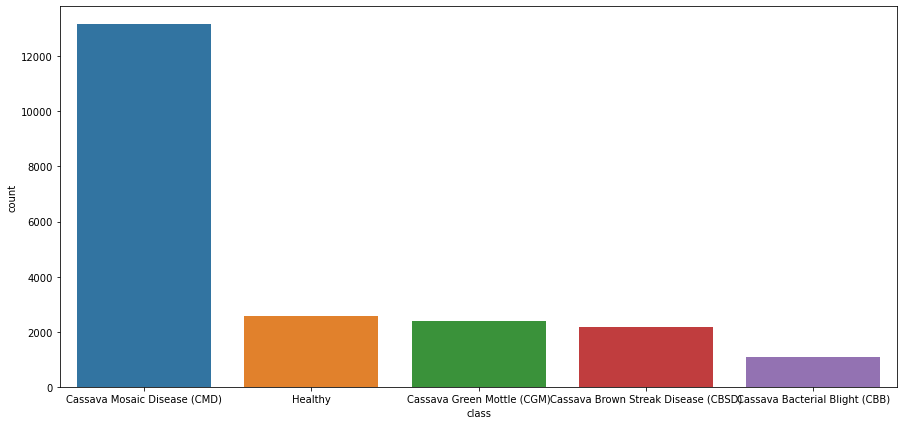

In [6]:
plt.figure(figsize = (15,7))
ax =sns.countplot(x=train['class'],order=train['class'].value_counts().index )
plt.show()


In [7]:
train['path'] = train['image_id'].apply(lambda x:'../input/cassava-leaf-disease-classification/train_images/'+str(x))
train= train.astype('str')
train, val = train_test_split(train, test_size = 0.05, random_state = 100,
                                    stratify = train['label'].values)

In [8]:
train

,image_id,label,class,path
4380,1782504875.jpg,3,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/t...
8516,2510432312.jpg,1,Cassava Brown Streak Disease (CBSD),../input/cassava-leaf-disease-classification/t...
12156,3177385615.jpg,3,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/t...
843,1144657211.jpg,3,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/t...
11656,3083709304.jpg,4,Healthy,../input/cassava-leaf-disease-classification/t...
...,...,...,...,...
15030,3699866059.jpg,0,Cassava Bacterial Blight (CBB),../input/cassava-leaf-disease-classification/t...
13538,3419923779.jpg,4,Healthy,../input/cassava-leaf-disease-classification/t...
19960,721245068.jpg,3,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/t...
18228,4280947903.jpg,3,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/t...


In [9]:
batch_size=4
def transform(image):
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=40),
        A.HorizontalFlip(),
        A.Transpose(p=0.5)
        
    ])
    return aug(image=image)['image']


datagen = ImageDataGenerator(preprocessing_function=transform)\
    .flow_from_dataframe(batch_size=batch_size,
        dataframe=train,
        directory=os.path.join(INPUT_DIR, 'train_images'),
        shuffle=True,
        x_col='image_id',
        y_col='label',
        target_size=(512,512), 
        class_mode='categorical'
    )

Found 20327 validated image filenames belonging to 5 classes.


In [10]:
val_datagen = ImageDataGenerator()\
    .flow_from_dataframe(batch_size=batch_size,
        dataframe=val,
        directory=os.path.join(INPUT_DIR, 'train_images'),
        shuffle=True,
        x_col='image_id',
        y_col='label',
        target_size=(512,512), 
        class_mode='categorical'
    )

Found 1070 validated image filenames belonging to 5 classes.


In [11]:
model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(512, 512, 3),
    pooling=None,
    #classes=1000,
    classifier_activation="softmax",
)


for layer in model.layers:
   layer.trainable = True

x = model.output


pool1=tf.keras.layers.GlobalAveragePooling2D()(x)
flat1 = tf.keras.layers.Flatten()(pool1)

class1 = tf.keras.layers.Dense(512, activation='relu')(flat1)
batch1 = tf.keras.layers.BatchNormalization()(class1)
dropout1=tf.keras.layers.Dropout(0.3)(batch1)
class2 = tf.keras.layers.Dense(512, activation='relu')(dropout1)
batch2 = tf.keras.layers.BatchNormalization()(class1)
dropout2=tf.keras.layers.Dropout(0.4)(batch2)
predictions = tf.keras.layers.Dense(5, activation='softmax')(dropout2)

71688192/71686520 [==============================] - 1s 0us/step


In [15]:
new_modelf = tf.keras.Model(inputs=model.input, outputs=predictions)
new_modelf.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(
                learning_rate=0.000012,
                beta_1=0.9,
                beta_2=0.999)
                ,
              metrics=['accuracy'])
new_modelf.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [16]:
checkpoint = ModelCheckpoint("./weightEffnetB4_v6.h5",

                         monitor='val_accuracy', 
                         #verbose=1, 
                         save_best_only=True, 
                         mode='max', 
                         save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto') 
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001, mode = 'min', verbose = 1)

In [17]:
batch_size=4
histfinal3 =new_modelf.fit(datagen, steps_per_epoch=20327// batch_size,
                            validation_data= val_datagen, validation_steps=1070// batch_size, epochs=20, callbacks=[checkpoint,early,reduce_lr])

Epoch 1/20
5081/5081 [==============================] - 1999s 393ms/step - loss: 1.4263 - accuracy: 0.5117 - val_loss: 1.1864 - val_accuracy: 0.6723
Epoch 2/20
5081/5081 [==============================] - 2007s 395ms/step - loss: 0.9832 - accuracy: 0.6590 - val_loss: 0.8962 - val_accuracy: 0.7678
Epoch 3/20
5081/5081 [==============================] - 2002s 394ms/step - loss: 0.8045 - accuracy: 0.7229 - val_loss: 0.7669 - val_accuracy: 0.8184
Epoch 4/20
5081/5081 [==============================] - 2004s 394ms/step - loss: 0.6957 - accuracy: 0.7593 - val_loss: 0.7644 - val_accuracy: 0.8361
Epoch 5/20
5081/5081 [==============================] - 1993s 392ms/step - loss: 0.6320 - accuracy: 0.7839 - val_loss: 0.7055 - val_accuracy: 0.8474
Epoch 6/20
5081/5081 [==============================] - 1996s 393ms/step - loss: 0.5810 - accuracy: 0.8097 - val_loss: 0.6892 - val_accuracy: 0.8474
Epoch 7/20
5081/5081 [==============================] - 1998s 393ms/step - loss: 0.5414 - accuracy: 0.8177

In [25]:
histfinal3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

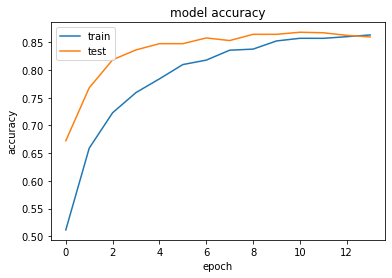

In [28]:

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

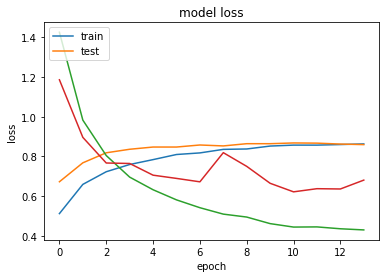

In [29]:
plt.plot(histfinal3.history['loss'])
plt.plot(histfinal3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
predictions = []



In [13]:
from keras.models import load_model
model = load_model("../input/test-5/weightEffnetB7_v6.h5")
model2=load_model("../input/mdpa56/initialweightInceptionResnet4.h5")

In [14]:
def agg_preds(predictions, y):
    y_classes = np.argmax(y, axis=1)
    acc_hist = []

    for i in range(predictions.shape[0]):
        pred_agg = np.mean(predictions[:i+1], axis=0)
        preds = np.argmax(pred_agg, axis=1)
        acc = preds == y_classes
        acc = np.mean(acc)
        acc_hist.append(acc)
    return acc_hist


In [15]:
def agg_acc(predictions, y):
    pred_agg = np.mean(predictions, axis=0)
    preds = np.argmax(pred_agg, axis=1)
    acc = np.mean(preds == y)
    return acc

In [16]:
def transfor(transfo,images):
    test=[]
    for i in images:
        test.append(transfo(i))
    return test
def flip_lr(image):
    aug = A.Compose([
        A.VerticalFlip(p=1)
        
    ])
    return aug(image=image)['image']

def rotate(image):
    aug = A.Compose([
         A.Rotate(limit=50,p=1)
        
    ])
    return aug(image=image)['image']
def flip_hor(image):

    aug = A.Compose([
        A.HorizontalFlip(p=1)
        
    ])
    return aug(image=image)['image']
    
def dropout(image):
        aug = A.Compose([
            A.augmentations.transforms.GridDropout (ratio=0.25, 
                                            unit_size_min=None, 
                                            unit_size_max=None, 
                                            holes_number_x=None, 
                                            holes_number_y=None, 
                                            shift_x=0, 
                                            shift_y=0, 
                                            random_offset=False, 
                                            fill_value=0, 
                                            mask_fill_value=None, 
                                            always_apply=False, 
                                            p=1)
             ])
        return aug(image=image)['image']
def perspec(image):
        aug = A.Compose([
            A.augmentations.geometric.transforms.Perspective (scale=(0.02, 0.1),p=1)
        ])
        return aug(image=image)['image']

In [17]:
val=val.reset_index()

In [18]:
list_image=val['path'].to_list()
list_image

['../input/cassava-leaf-disease-classification/train_images/1748255784.jpg',
 '../input/cassava-leaf-disease-classification/train_images/3930711994.jpg',
 '../input/cassava-leaf-disease-classification/train_images/3276660175.jpg',
 '../input/cassava-leaf-disease-classification/train_images/630797550.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1139923759.jpg',
 '../input/cassava-leaf-disease-classification/train_images/2760326130.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1459667255.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1338027879.jpg',
 '../input/cassava-leaf-disease-classification/train_images/4264274445.jpg',
 '../input/cassava-leaf-disease-classification/train_images/296985472.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1258444443.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1227037635.jpg',
 '../input/cassava-leaf-disease-classification/train_images/224577938.jpg',
 '

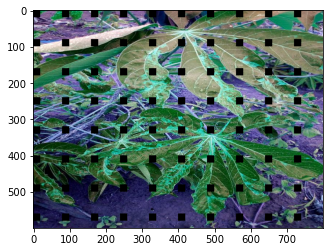

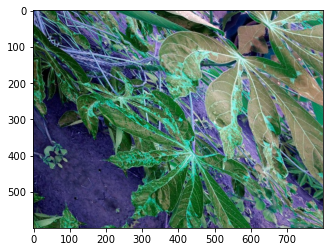

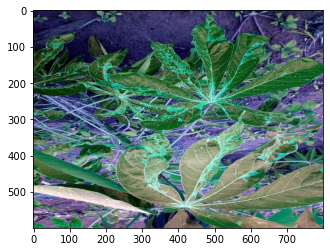

In [19]:
plt.imshow(dropout(cv2.imread(list_image[0])))
plt.show()
plt.imshow(rotate(cv2.imread(list_image[0])))
plt.show()
plt.imshow(flip_lr(cv2.imread(list_image[0])))

In [ ]:
x_test=val1
#model

In [ ]:
def predict2(model,b):
    test=[]
    for i in b:
        test.append(model.predict(np.expand_dims(i,axis=0))[0])
    return test

In [ ]:
y_test=val['label'].to_list()

def agg_acc(stacked,y_test):
    #preds_f = np.stack((pred, pred_v))
    predi=np.mean(stacked,axis=0)
    preds = np.argmax(predi, axis=1)
    #acc=np.mean(preds==y_test)
    return accuracy_score(preds,y_test)

In [20]:
val2=[]
for image in test_images:
    img=np.expand_dims(((cv2.cvtColor(cv2.imread(TEST_DIR + image),cv2.COLOR_BGR2RGB))),axis=0)
    pred = model2.predict(img)+model.predict(img)
    pred_v = model2.predict(flip_lr(img))+model.predict(flip_lr(img))
    pred_k = model2.predict(rotate(img))+model.predict(rotate(img))
    pred_h = model2.predict(flip_hor(img))+ model.predict(flip_hor(img))
    pred_dropout = model2.predict(dropout(img))+model.predict(dropout(img))
    preds_fhw = np.stack((pred, pred_h, pred_v, pred_dropout,pred_k))
    predi=np.mean(preds_fhw,axis=0)
    preds = np.argmax(predi, axis=1)
    val2.append(preds[0])

NameError: name 'test_images' is not defined

In [21]:
val2=[]
val3=[]
val1=[]
valk=[]
valh=[]
valdrop=[]
valfhw=[]
for image in list_image:
    img=np.expand_dims(((cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))),axis=0)
    pred = model.predict(img)#+model.predict(img)
    val1.append(np.argmax(pred, axis=1))
    pred2 = model2.predict(img)#+model.predict(img)
    val2.append(np.argmax(pred2, axis=1))
    val3.append(np.argmax(pred+pred2,axis=1))
    

<BarContainer object of 2 artists>

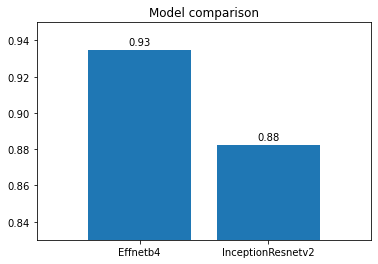

In [31]:
valtot=[val1,val2]
accuracy1=[]
y=[]
for i in val['label'].to_list():
    y.append(int(i))
for i in range(len(valtot)):
    accuracy1.append(accuracy_score(y,valtot[i]))
fig, ax = plt.subplots()

for rect in [0,1]:
    ax.annotate( "%.2f" % accuracy1[rect],
                xy=(rect,accuracy1[rect]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.axis([-0.8,1.8, 0.83, 0.95])
plt.title('Model comparison')
plt.bar(x=['Effnetb4','InceptionResnetv2'],height=accuracy1)

<BarContainer object of 3 artists>

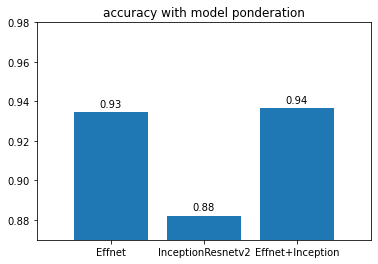

In [30]:
valtot=[val1,val2,val3]
accuracy1=[]
y=[]
for i in val['label'].to_list():
    y.append(int(i))
for i in range(len(valtot)):
    accuracy1.append(accuracy_score(y,valtot[i]))
fig, ax = plt.subplots()
for rect in [0,1,2]:
    ax.annotate( "%.2f" % accuracy1[rect],
                xy=(rect,accuracy1[rect]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.axis([-0.8,2.8, 0.87, 0.98])
plt.title('accuracy with model ponderation')
plt.bar(x=['Effnet','InceptionResnetv2','Effnet+Inception'],height=accuracy1)

val2=[]
valv=[]
val1=[]
valk=[]
valh=[]
valdrop=[]
valfhw=[]
for image in list_image:
    img=np.expand_dims(((cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))),axis=0)
    pred = model2.predict(img)+model.predict(img)
    val1.append(np.argmax(pred, axis=1))
    pred_v = model2.predict(flip_lr(img))+model.predict(flip_lr(img))
    pred_v=np.stack((pred_v,pred))
    pred_v=np.mean(pred_v,axis=0)
    valv.append(np.argmax(pred_v, axis=1)[0])
    img2=np.expand_dims((rotate(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))),axis=0)
    pred_k = model2.predict(img2)+model.predict(img2)
    pred_k=np.stack((pred_k,pred))
    pred_k=np.mean(pred_k,axis=0)
    valk.append(np.argmax(pred_k, axis=1)[0])
    pred_h = model2.predict(flip_hor(img))+ model.predict(flip_hor(img))
    pred_h=np.stack((pred_h,pred))
    pred_h=np.mean(pred_h,axis=0)
    valh.append(np.argmax(pred_h, axis=1)[0])
    pred_dropout = model2.predict(dropout(img))+model.predict(dropout(img))
    pred_dropout = np.stack((pred,pred_dropout))
    pred_dropout=np.mean(pred_dropout,axis=0)
    valdrop.append(np.argmax(pred_dropout, axis=1)[0])
    preds_fhw = np.stack((pred, pred_h, pred_v, pred_dropout,pred_k))
    preds_fhw=np.mean(preds_fhw,axis=0)
    valfhw.append(np.argmax(preds_fhw, axis=1)[0])

val2=[]
valv=[]
val1=[]
valk=[]
valh=[]
valdrop=[]
valfhw=[]
for image in list_image:
    img=np.expand_dims(((cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))),axis=0)
    pred = model2.predict(img)+model.predict(img)
    val1.append(np.argmax(pred, axis=1))
    pred_v = model2.predict(flip_lr(img))+model.predict(flip_lr(img))
    pred_v=np.stack((pred_v,pred))
    pred_v=np.mean(pred_v,axis=0)
    valv.append(np.argmax(pred_v, axis=1)[0])
    img2=np.expand_dims((rotate(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))),axis=0)
    pred_k = model2.predict(img2)+model.predict(img2)
    pred_k=np.stack((pred_k,pred))
    pred_k=np.mean(pred_k,axis=0)
    valk.append(np.argmax(pred_k, axis=1)[0])
    pred_h = model2.predict(flip_hor(img))+ model.predict(flip_hor(img))
    pred_h=np.stack((pred_h,pred))
    pred_h=np.mean(pred_h,axis=0)
    valh.append(np.argmax(pred_h, axis=1)[0])
    pred_dropout = model2.predict(dropout(img))+model.predict(dropout(img))
    pred_dropout = np.stack((pred,pred_dropout))
    pred_dropout=np.mean(pred_dropout,axis=0)
    valdrop.append(np.argmax(pred_dropout, axis=1)[0])
    preds_fhw = np.stack((pred, pred_h, pred_v, pred_dropout,pred_k))
    preds_fhw=np.mean(preds_fhw,axis=0)
    valfhw.append(np.argmax(preds_fhw, axis=1)[0])

preds_hw = np.stack((pred, pred_dropout2))
agg_acc(preds_hw, y_test)

accuracy

In [ ]:
val2=[]
for image in test_images:
    img=np.expand_dims(((cv2.cvtColor(cv2.imread(TEST_DIR + image),cv2.COLOR_BGR2RGB))),axis=0)
    pred = model2.predict(img)+model.predict(img)
    pred_v = model2.predict(flip_lr(img))+model.predict(flip_lr(img))
    img2=rotate((cv2.cvtColor(cv2.imread(TEST_DIR + image),cv2.COLOR_BGR2RGB)))
    img2=np.expand_dims(img2,axis=0)
    pred_k = model2.predict(img2)+model.predict(img2)
    pred_h = model2.predict(flip_hor(img))+ model.predict(flip_hor(img))
    #pred_dropout = model2.predict(dropout(img))+model.predict(dropout(img))
    preds_fhw = np.stack((pred, pred_h, pred_v,pred_k))
    predi=np.mean(preds_fhw,axis=0)
    preds = np.argmax(predi, axis=1)
    val2.append(preds[0])

In [ ]:
submission = pd.DataFrame({'image_id': test_images, 'label': val2})
submission.to_csv('submission.csv', index = False)

In [ ]:
submission